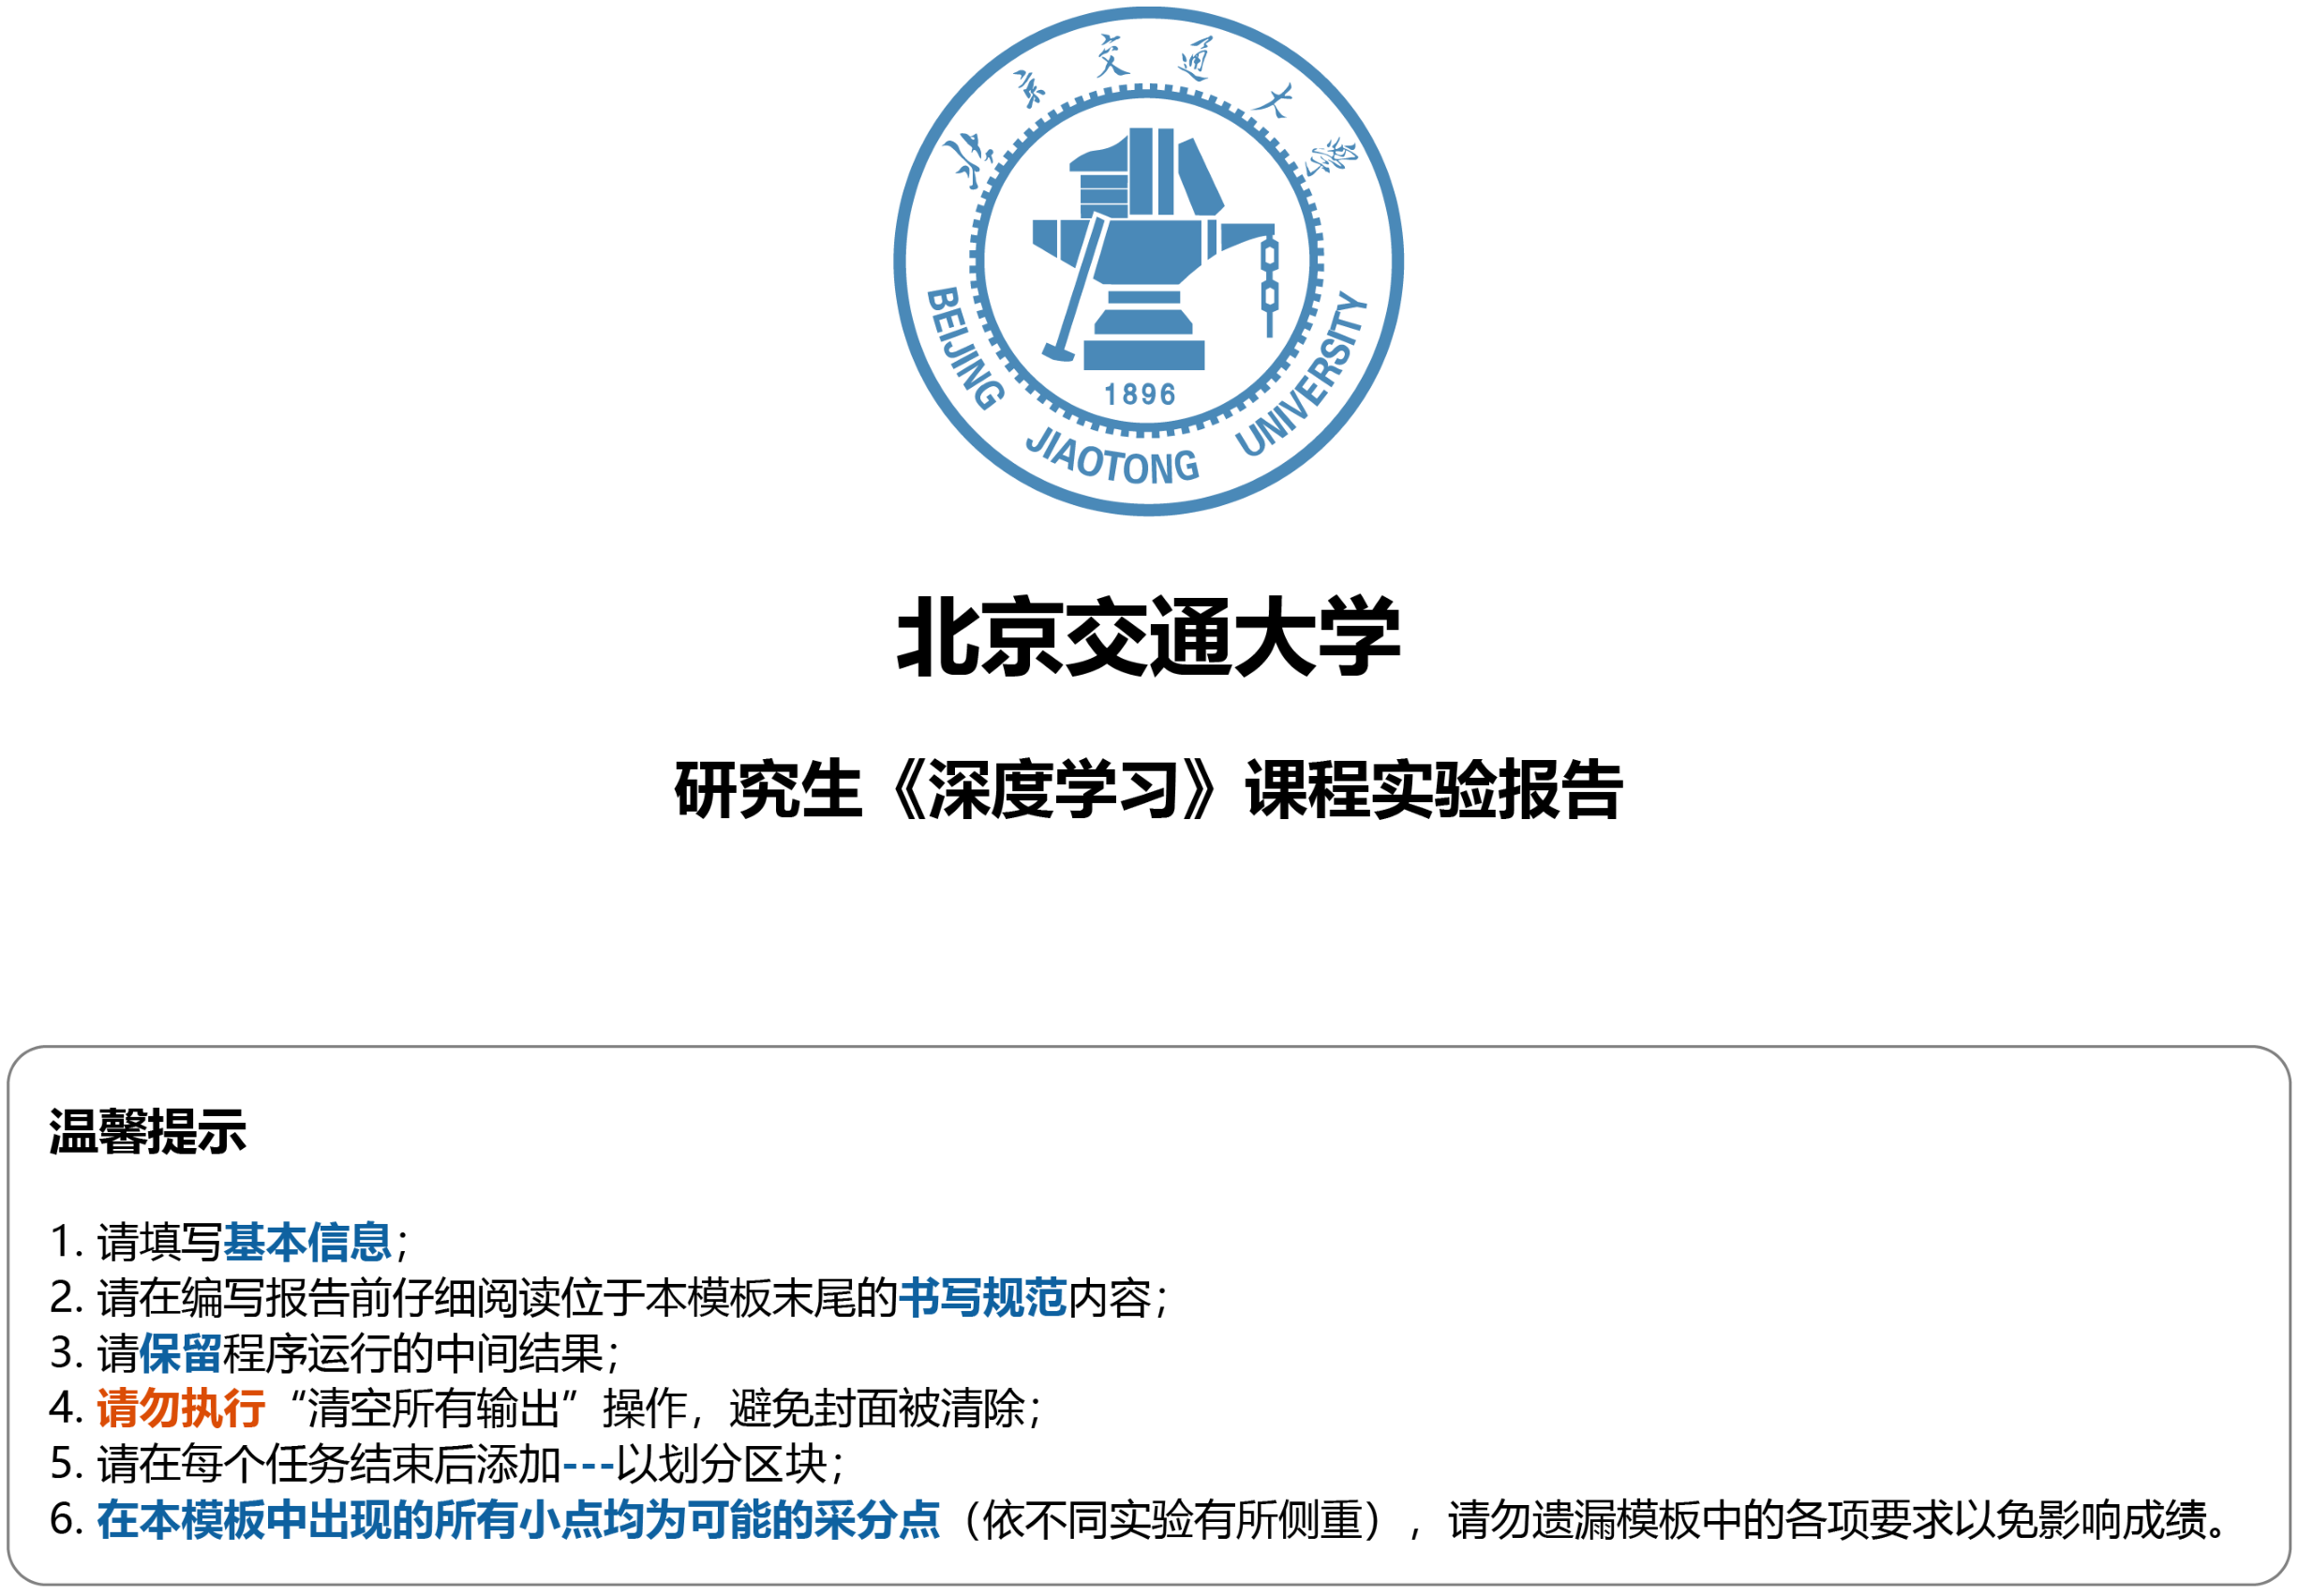

# 基本信息
1. 实验名称：循环神经网络实验
2. 姓名：崔晓澍
3. 学号：23140028
4. 日期：2023.9.11

---

# 一、任务1

## 1.1 手动或调用接口方式实现RNN

1. 任务具体要求：分别采用手动方式以及调用接口方式实现RNN，并在至少一个数据集上进行实验
2. 任务目的：实现RNN
3. 任务算法或原理介绍
4. 任务所用数据集：高速公路车流量数据

## 1.2 任务思路及代码

> 以文本步骤的形式简要介绍代码思路
1. 步骤1：读取数据
2. 步骤2：定义模型
3. 步骤3：训练模型

## 1.3 实验结果分析

**实验代码**

In [1]:
import math
import torch
from torch import nn
import numpy as np
import pandas as pd
import torch.utils.data as data
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 定义dataset
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class TrafficDataset:
    def __init__(self, sensor=10, target=0):
        # 选取适当的检测器用作序列数据
        self.raw_data = np.load("C:/Users/lpn/Desktop/RNN/traffic.npz")['data']
        self.sensor = sensor
        self.target = target
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []


        len_train = int(self.data.shape[0] * train_por)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i+window_size, self.sensor, :].squeeze())
            train_y.append(train_seqs[i+window_size, self.sensor, self.target].squeeze())

        len_val = int(self.data.shape[0] * (train_por + test_por))
        val_seqs = self.data[len_train:len_val]
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(val_seqs[i:i+window_size, self.sensor, :].squeeze())
            val_y.append(val_seqs[i+window_size, self.sensor, self.target].squeeze())

        test_seqs = self.data[len_val:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i+window_size, self.sensor, :].squeeze())
            test_y.append(test_seqs[i+window_size, self.sensor, self.target].squeeze())

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

In [3]:
#读取数据
TrafficData = TrafficDataset()
train_set, val_set, test_set = TrafficData.construct_set(0.6, 0.2)

batch_size = 64
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
train_loader
train_set.X.shape[-1]

3

**手动实现RNN**

In [4]:
# 模型
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        :param input_size: 指定输入数据的维度。例如，对于简单的时间序列预测问题，每一步的输入均为一个采样值，因此input_size=1.
        :param hidden_size: 指定隐藏状态的维度。这个值并不受输入和输出控制，但会影响模型的容量。
        :param output_size: 指定输出数据的维度。此值取决于具体的预测要求。例如，对简单的时间序列预测问题，output_size=1.
        """
        super().__init__()
        self.hidden_size = hidden_size
        
        # 可学习参数的维度设置，可以类比一下全连接网络的实现。其维度取决于输入数据的维度，以及指定的隐藏状态维度。
        self.w_h = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        
        self.w_y = nn.Parameter(torch.rand(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))
        
        # 准备激活函数。Dropout函数可选。
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU()
        
        # 可选：使用性能更好的参数初始化函数
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        """
        :param x: 输入序列。一般来说，此输入包含三个维度：batch，序列长度，以及每条数据的特征。
        """
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # 初始化隐藏状态，一般设为全0。由于是内部新建的变量，需要同步设备位置。
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        # RNN实际上只能一步一步处理序列。因此需要用循环迭代。
        y_list = []
        for i in range(seq_len):
            h = self.tanh(torch.matmul(x[:, i, :], self.w_h) + 
                             torch.matmul(h, self.u_h) + self.b_h)  # (batch_size, hidden_size)
            y = self.leaky_relu(torch.matmul(h, self.w_y) + self.b_y)  # (batch_size, output_size)
            y_list.append(y)
        # 一般来说，RNN的返回值为最后一步的隐藏状态，以及每一步的输出状态。
        return torch.stack(y_list, dim=1), h

In [5]:
#模型初始化
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)

optimizer = torch.optim.Adam(my_rnn.parameters(), lr)

In [6]:
#预测性能
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [7]:
#训练
from utils import *

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.0089, train rmse 98.4131, val loss 0.0040, val rmse 62.896885, time use 1.632s
*** epoch2, train loss 0.0033, train rmse 65.0553, val loss 0.0031, val rmse 52.366134, time use 1.587s
*** epoch3, train loss 0.0027, train rmse 58.4282, val loss 0.0030, val rmse 51.888242, time use 1.650s
*** epoch4, train loss 0.0025, train rmse 55.7688, val loss 0.0026, val rmse 46.789646, time use 1.497s
*** epoch5, train loss 0.0023, train rmse 53.7259, val loss 0.0025, val rmse 45.882292, time use 1.535s
*** epoch6, train loss 0.0022, train rmse 52.4248, val loss 0.0024, val rmse 44.071016, time use 2.104s
*** epoch7, train loss 0.0021, train rmse 51.4503, val loss 0.0023, val rmse 43.228623, time use 2.249s
*** epoch8, train loss 0.0021, train rmse 50.6676, val loss 0.0024, val rmse 44.502060, time use 2.107s
*** epoch9, train loss 0.0020, train rmse 50.4442, val loss 0.0022, val rmse 42.340888, time use 2.159s
*** epoch10, train loss 0.0019, train rmse 49.4712, val loss 0.0

### 1.3.1 手动实现RNN实验结果分析

手动实现RNN，随着训练次数增加，训练集和测试集预测的误差值loss呈先下降后平缓的大致趋势，证明了模型有很强的学习能力。而且在手动实现RNN的过程中出现了早停，模型大概20轮没有被继续改善。训练时间大概3min.

具体结果如下图所示。

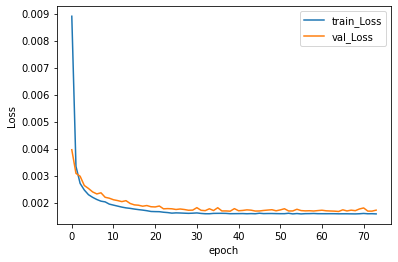

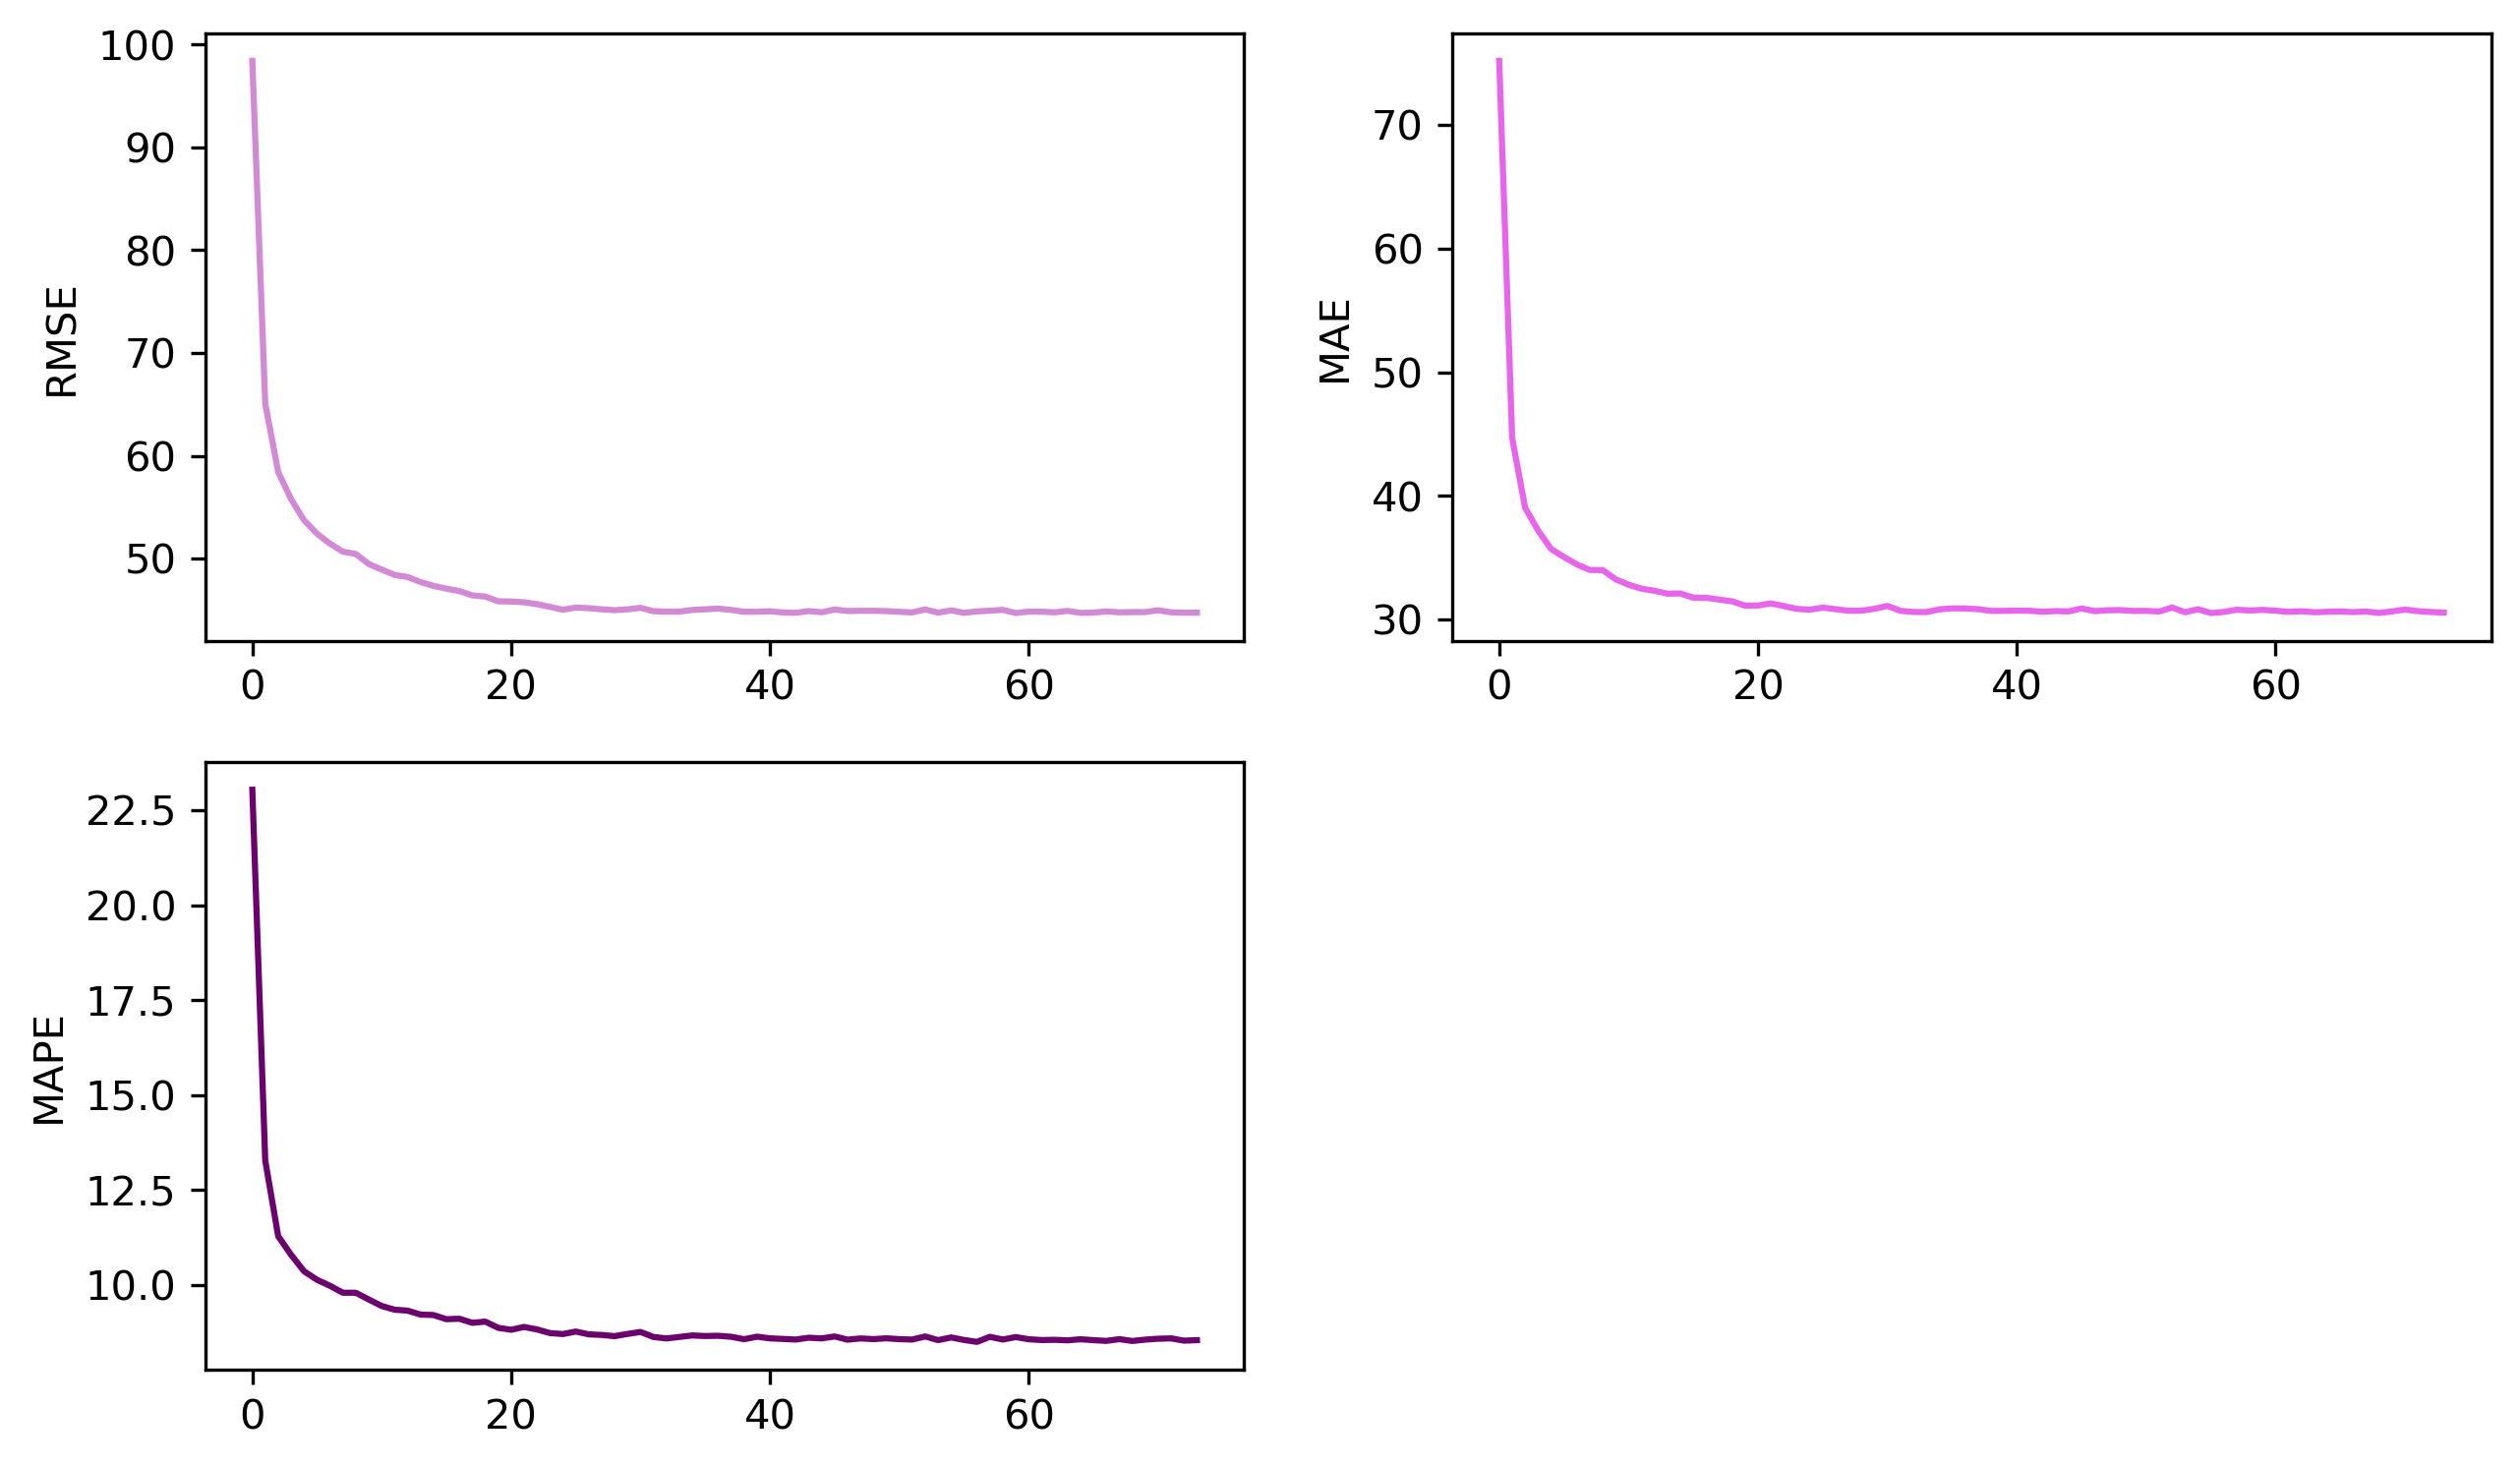

In [8]:
#可视化
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

**使用封装的RNN**

In [9]:
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

nn_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch1, train loss 0.0482, train rmse 225.9027, val loss 0.0121, val rmse 115.831103, time use 1.178s
*** epoch2, train loss 0.0060, train rmse 84.4532, val loss 0.0028, val rmse 51.443806, time use 1.200s
*** epoch3, train loss 0.0028, train rmse 60.3522, val loss 0.0027, val rmse 50.106198, time use 1.291s
*** epoch4, train loss 0.0027, train rmse 58.5637, val loss 0.0026, val rmse 49.350818, time use 1.327s
*** epoch5, train loss 0.0025, train rmse 56.6931, val loss 0.0025, val rmse 48.043726, time use 1.154s
*** epoch6, train loss 0.0024, train rmse 55.5968, val loss 0.0025, val rmse 48.149149, time use 1.171s
*** epoch7, train loss 0.0023, train rmse 54.0384, val loss 0.0023, val rmse 45.245460, time use 1.230s
*** epoch8, train loss 0.0022, train rmse 52.4181, val loss 0.0022, val rmse 44.318402, time use 1.452s
*** epoch9, train loss 0.0021, train rmse 51.5069, val loss 0.0022, val rmse 43.935304, time use 1.577s
*** epoch10, train loss 0.0020, train rmse 50.7641, val loss 0

*** epoch80, train loss 0.0016, train rmse 44.8783, val loss 0.0018, val rmse 38.679789, time use 1.539s

****************************************
Final result:
Get best validation rmse 36.8464 at epoch 73
Total time 126.60s

Test result:
Test RMSE: 37.398482121155176    Test MAE: 26.518984378467906    Test MAPE: 8.434766260060398


### 1.3.2 调用接口实现RNN实验结果分析

调用接口方式实现RNN，实现图像大致与手动实现类似，随着训练次数增加，训练集和测试集预测的误差值loss呈先下降后平缓的大致趋势，证明了模型有很强的学习能力。训练时间大概2min左右。

具体结果如下图所示。

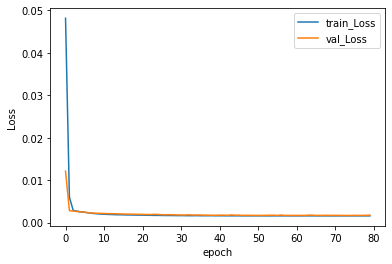

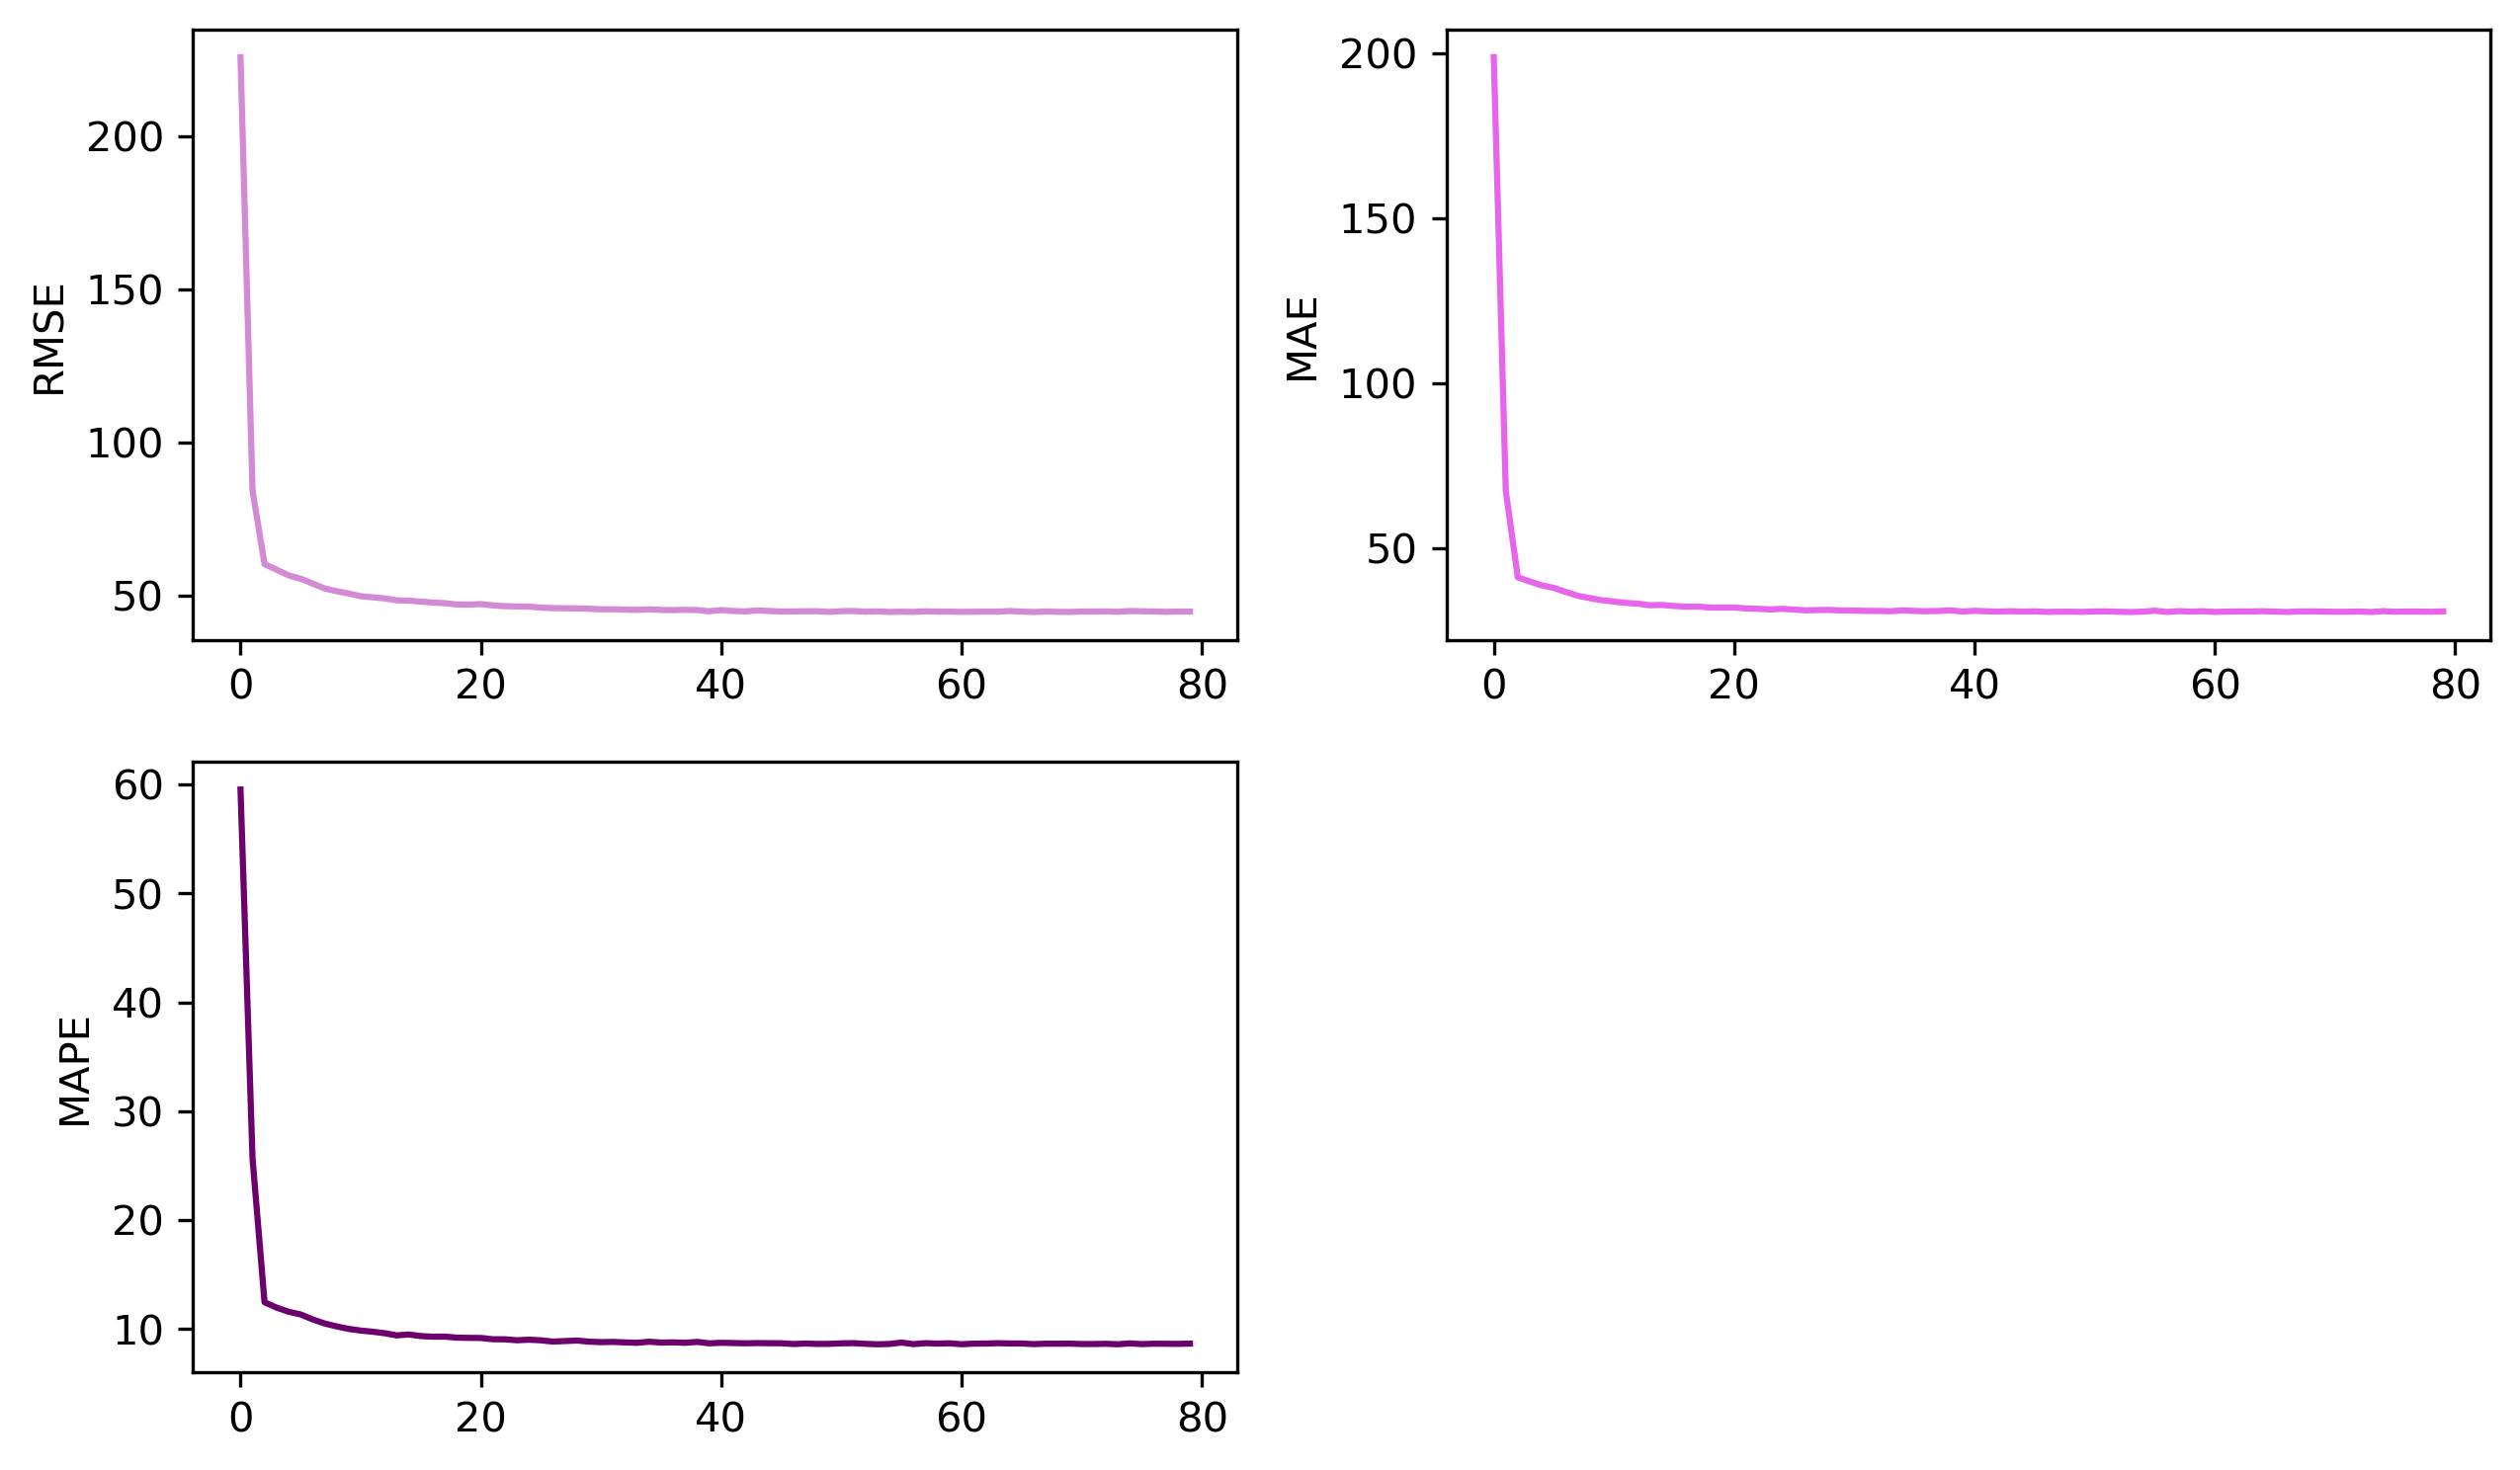

In [10]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

---

# 二、任务2

## 2.1 任务内容：手动或调用接口方式实现LSTM

1. 任务具体要求：采用手动方式以及调用接口方式实现LSTM，并在至少一种数据集上进行实验
2. 任务目的：实现LSTM
3. 任务算法或原理介绍
4. 任务所用数据集：高速公路车流量数据集

## 2.2 任务思路及代码

> 以文本步骤的形式简要介绍代码思路
1. 步骤1：读取数据
2. 步骤2：定义模型
3. 步骤3：训练模型

## 2.3 实验结果分析

In [11]:
# 实验代码
class My_legacyLSTM(nn.Module):
    def _init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.w_f = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_f = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_f = nn.Parameter(torch.zeros(hidden_size))

        self.w_i = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_i = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_i = nn.Parameter(torch.zeros(hidden_size))

        self.w_o = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_o = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_o = nn.Parameter(torch.zeros(hidden_size))

        self.w_c = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_c = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_c = nn.Parameter(torch.zeros(hidden_size))

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        # 需要初始化隐藏状态和细胞状态
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []
        for i in range(seq_len):
            forget_gate = self.sigmoid(torch.matmul(x[:, i, :], self.w_f) +
                                       torch.matmul(h, self.u_f) + self.b_f)
            # (batch_siz,hidden_size)
            input_gate = self.sigmoid(torch.matmul(x[:, i, :], self.w_i) +
                                      torch.matmul(h, self.u_i) + self.b_i)
            output_gate = self.sigmoid(torch.matmul(x[:, i, :], self.w_o) +
                                       torch.matmul(h, self.u_o) + self.b_o)
            # 这里可以看到各个门的运作方式。
            # 三个门均通过hadamard积作用在每一个维度上。
            c = forget_gate * c + input_gate * self.tanh(torch.matmul(x[:, i, :], self.w_c) +
                                                         torch.matmul(h, self.u_c) + self.b_c)
            h = output_gate * self.tanh(c)
            y_list.append(h)
        return torch.stack(y_list, dim=1), (h, c)

In [12]:
class My_LSTM(nn. Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gates = nn.Linear(input_size + hidden_size, hidden_size * 4)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn. Tanh()
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        h, c = (torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(2))
        y_list = []
        for i in range(seq_len):
            forget_gate, input_gate, output_gate, candidate_cell = \
                self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(4, -1)
            forget_gate, input_gate, output_gate = (self.sigmoid(g)
                                                    for g in (forget_gate, input_gate, output_gate))
            c = forget_gate * c + input_gate * self.tanh(candidate_cell)
            h = output_gate * self.tanh(c)
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), (h, c)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

my_rnn = My_LSTM(input_size, hidden_size, output_size).to(device)

optimizer = torch.optim.Adam(my_rnn.parameters(), lr)

In [14]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [15]:
from utils import *

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.1910, train rmse 483.7979, val loss 0.0282, val rmse 179.122224, time use 4.225s
*** epoch2, train loss 0.0142, train rmse 135.1842, val loss 0.0088, val rmse 98.472446, time use 4.093s
*** epoch3, train loss 0.0063, train rmse 89.9303, val loss 0.0041, val rmse 66.305719, time use 5.061s
*** epoch4, train loss 0.0033, train rmse 65.0902, val loss 0.0030, val rmse 54.298424, time use 5.512s
*** epoch5, train loss 0.0029, train rmse 60.1622, val loss 0.0029, val rmse 51.998449, time use 5.242s
*** epoch6, train loss 0.0028, train rmse 59.3463, val loss 0.0028, val rmse 50.972219, time use 5.491s
*** epoch7, train loss 0.0027, train rmse 58.6501, val loss 0.0027, val rmse 50.206818, time use 5.327s
*** epoch8, train loss 0.0026, train rmse 58.1163, val loss 0.0027, val rmse 49.298827, time use 5.439s
*** epoch9, train loss 0.0026, train rmse 57.0496, val loss 0.0026, val rmse 48.920773, time use 5.528s
*** epoch10, train loss 0.0025, train rmse 56.5898, val loss 

*** epoch80, train loss 0.0016, train rmse 44.4798, val loss 0.0017, val rmse 36.616250, time use 5.325s

****************************************
Final result:
Get best validation rmse 36.6163 at epoch 79
Total time 439.57s

Test result:
Test RMSE: 35.508311323939765    Test MAE: 24.6284723108465    Test MAPE: 7.58150243115696


### 2.3.1 手动实现LSTM实验结果分析

手动实现LSTM，随着训练次数增加，训练集和测试集预测的误差值loss呈先下降后平缓的大致趋势，证明了模型有很强的学习能力。训练时间大概7min左右，比手动实现RNN要时间更长一些。

具体结果如下图所示。

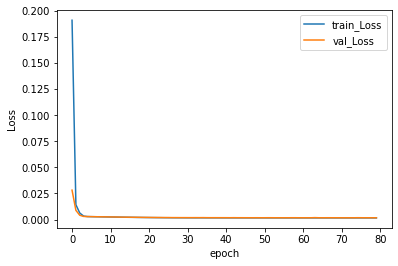

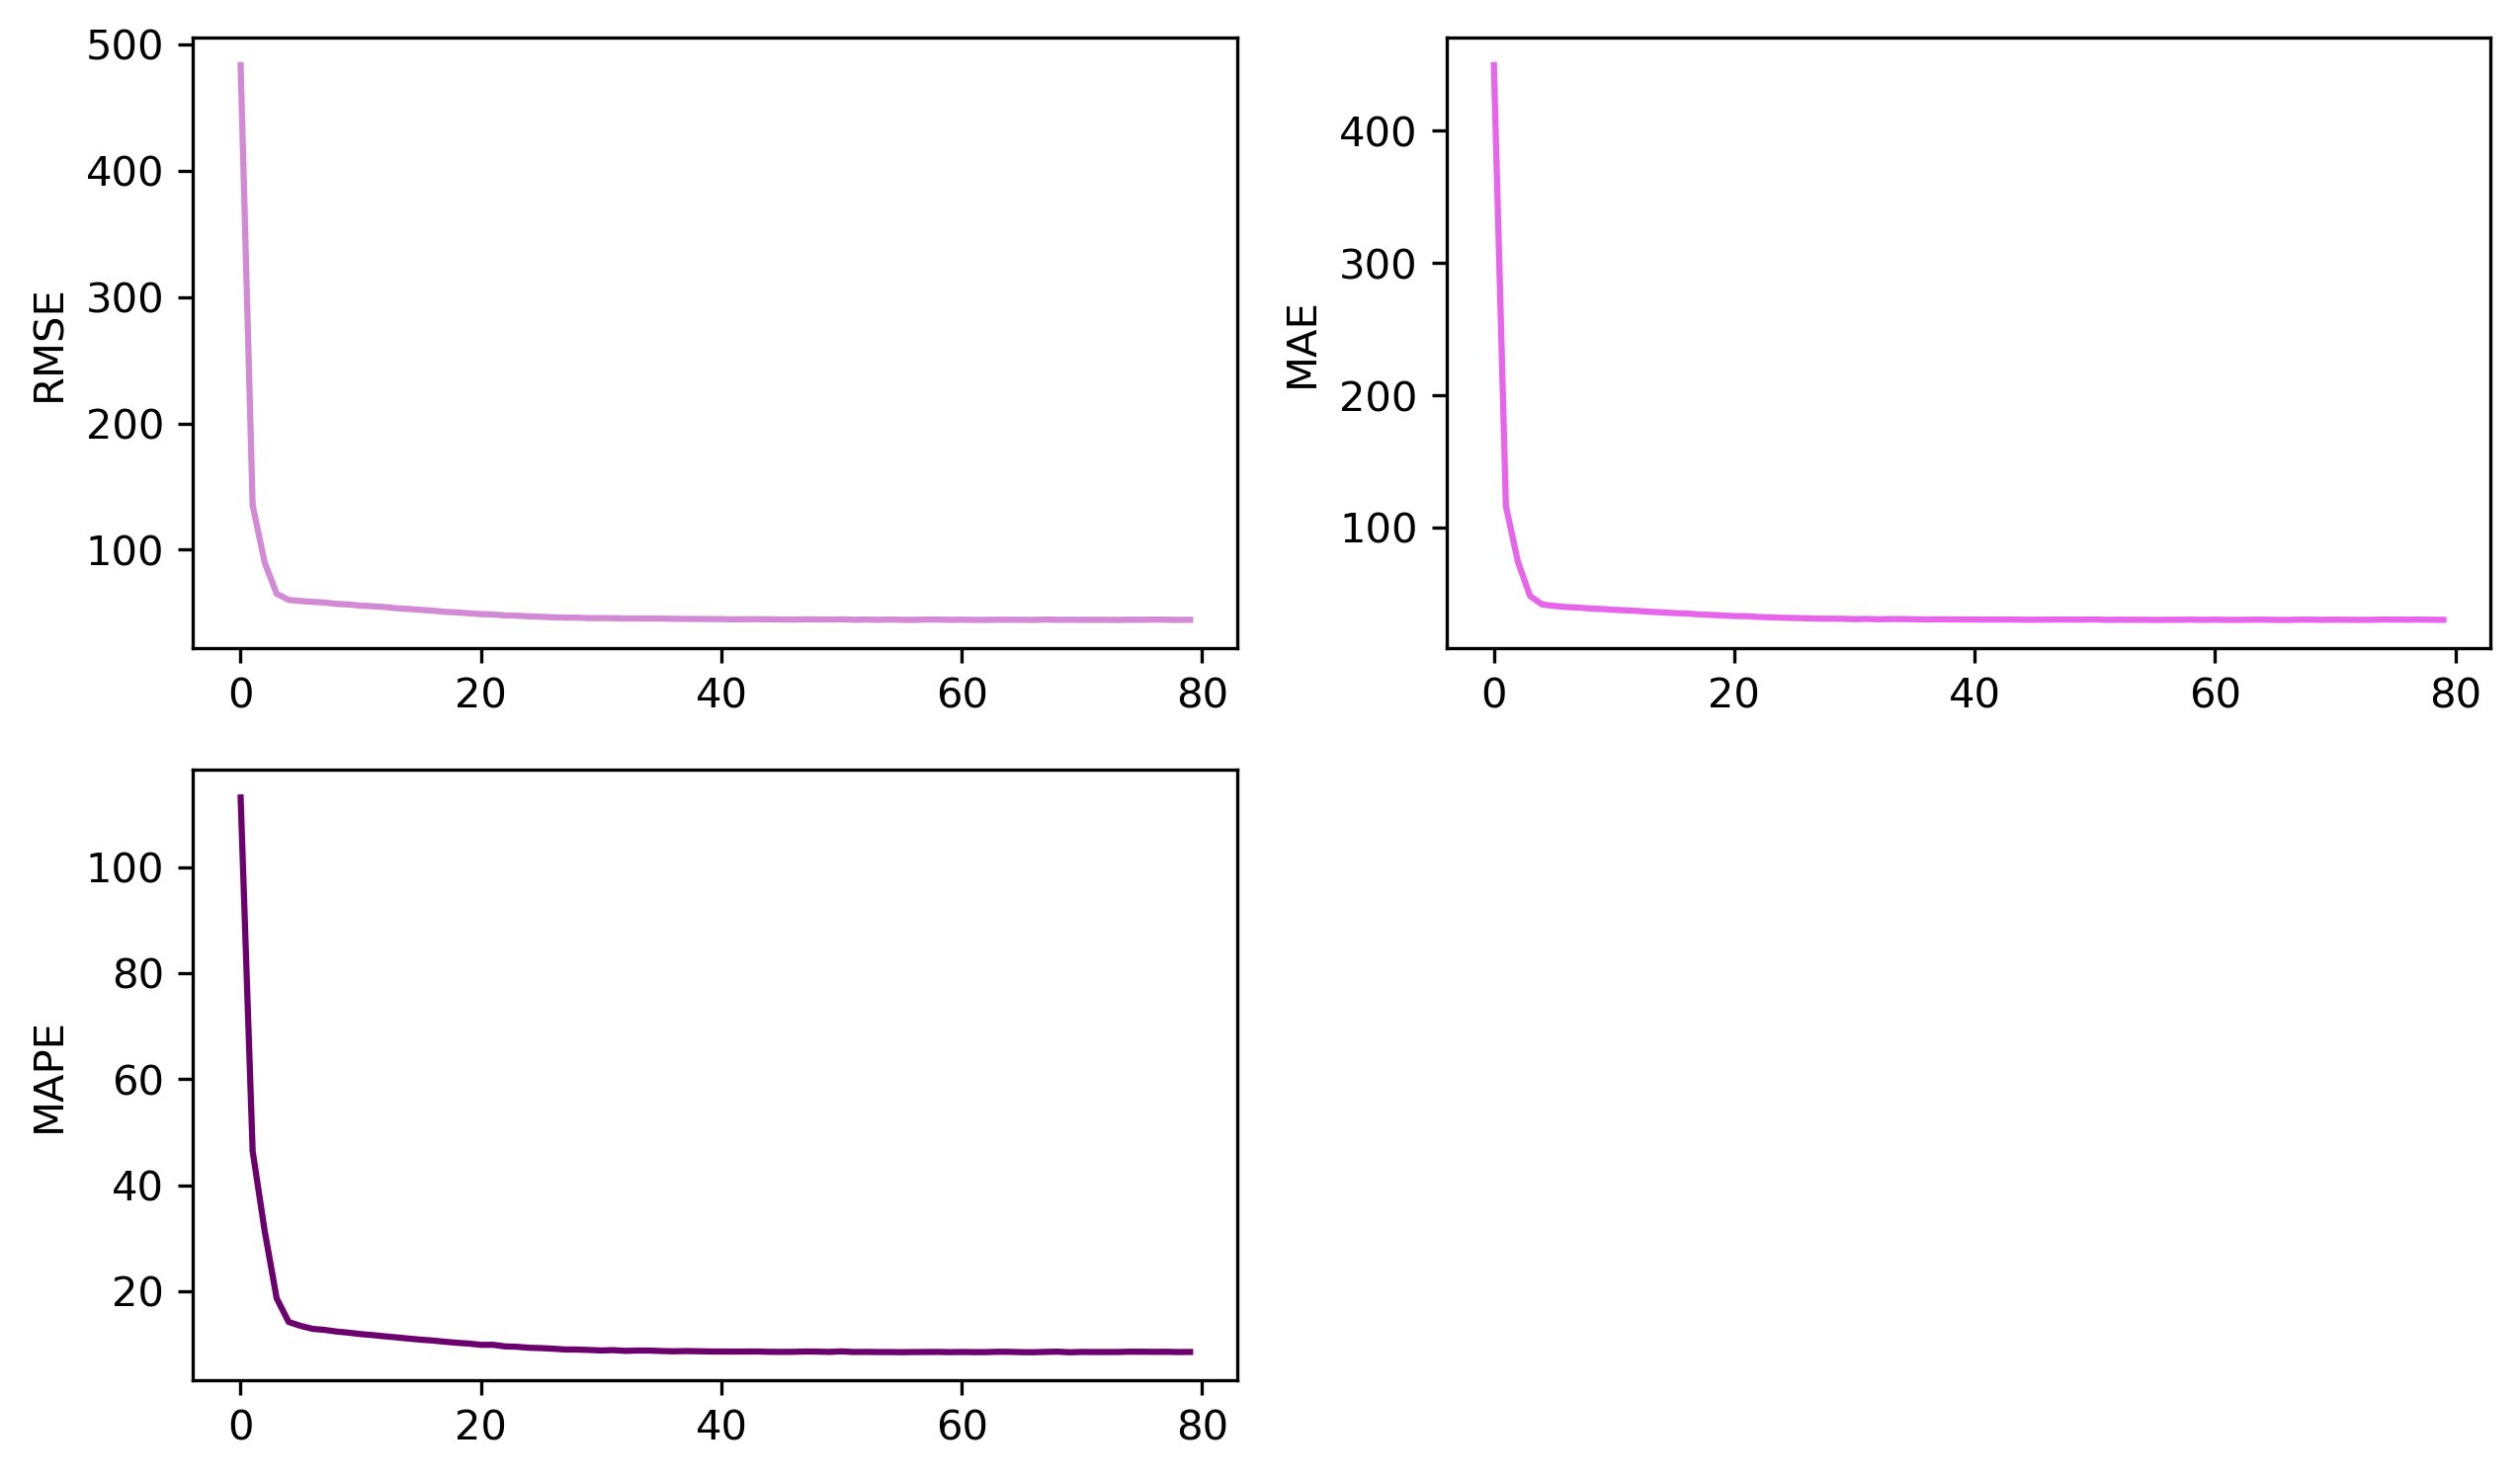

In [16]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

**使用封装的LSTM**

In [17]:
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

nn_rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch1, train loss 0.0536, train rmse 252.8976, val loss 0.0176, val rmse 135.998743, time use 3.286s
*** epoch2, train loss 0.0154, train rmse 141.8284, val loss 0.0111, val rmse 108.471195, time use 3.324s
*** epoch3, train loss 0.0071, train rmse 95.2398, val loss 0.0044, val rmse 67.708429, time use 3.929s
*** epoch4, train loss 0.0039, train rmse 71.2343, val loss 0.0040, val rmse 64.659040, time use 4.613s
*** epoch5, train loss 0.0038, train rmse 69.6177, val loss 0.0039, val rmse 63.515530, time use 4.444s
*** epoch6, train loss 0.0036, train rmse 67.9363, val loss 0.0036, val rmse 60.166121, time use 4.275s
*** epoch7, train loss 0.0035, train rmse 66.7681, val loss 0.0036, val rmse 60.301824, time use 5.081s
*** epoch8, train loss 0.0033, train rmse 65.4296, val loss 0.0034, val rmse 57.763420, time use 4.224s
*** epoch9, train loss 0.0032, train rmse 64.1360, val loss 0.0032, val rmse 55.841721, time use 4.419s
*** epoch10, train loss 0.0031, train rmse 62.9278, val loss

*** epoch80, train loss 0.0016, train rmse 44.9796, val loss 0.0017, val rmse 37.470638, time use 4.349s

****************************************
Final result:
Get best validation rmse 37.0926 at epoch 76
Total time 340.02s

Test result:
Test RMSE: 36.37375965934584    Test MAE: 25.4951190514998    Test MAPE: 7.993604493412104


### 2.3.2 调用接口方式实现LSTM结果分析

调用接口方式实现LSTM，实现图像大致与手动实现类似，随着训练次数增加，训练集和测试集预测的误差值loss呈先下降后平缓的大致趋势，证明了模型有很强的学习能力。模型大概训练时间为5min左右，比实现RNN要时间更长一些。

具体结果如下图所示。

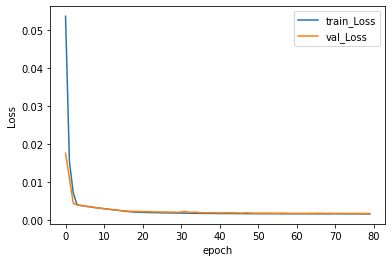

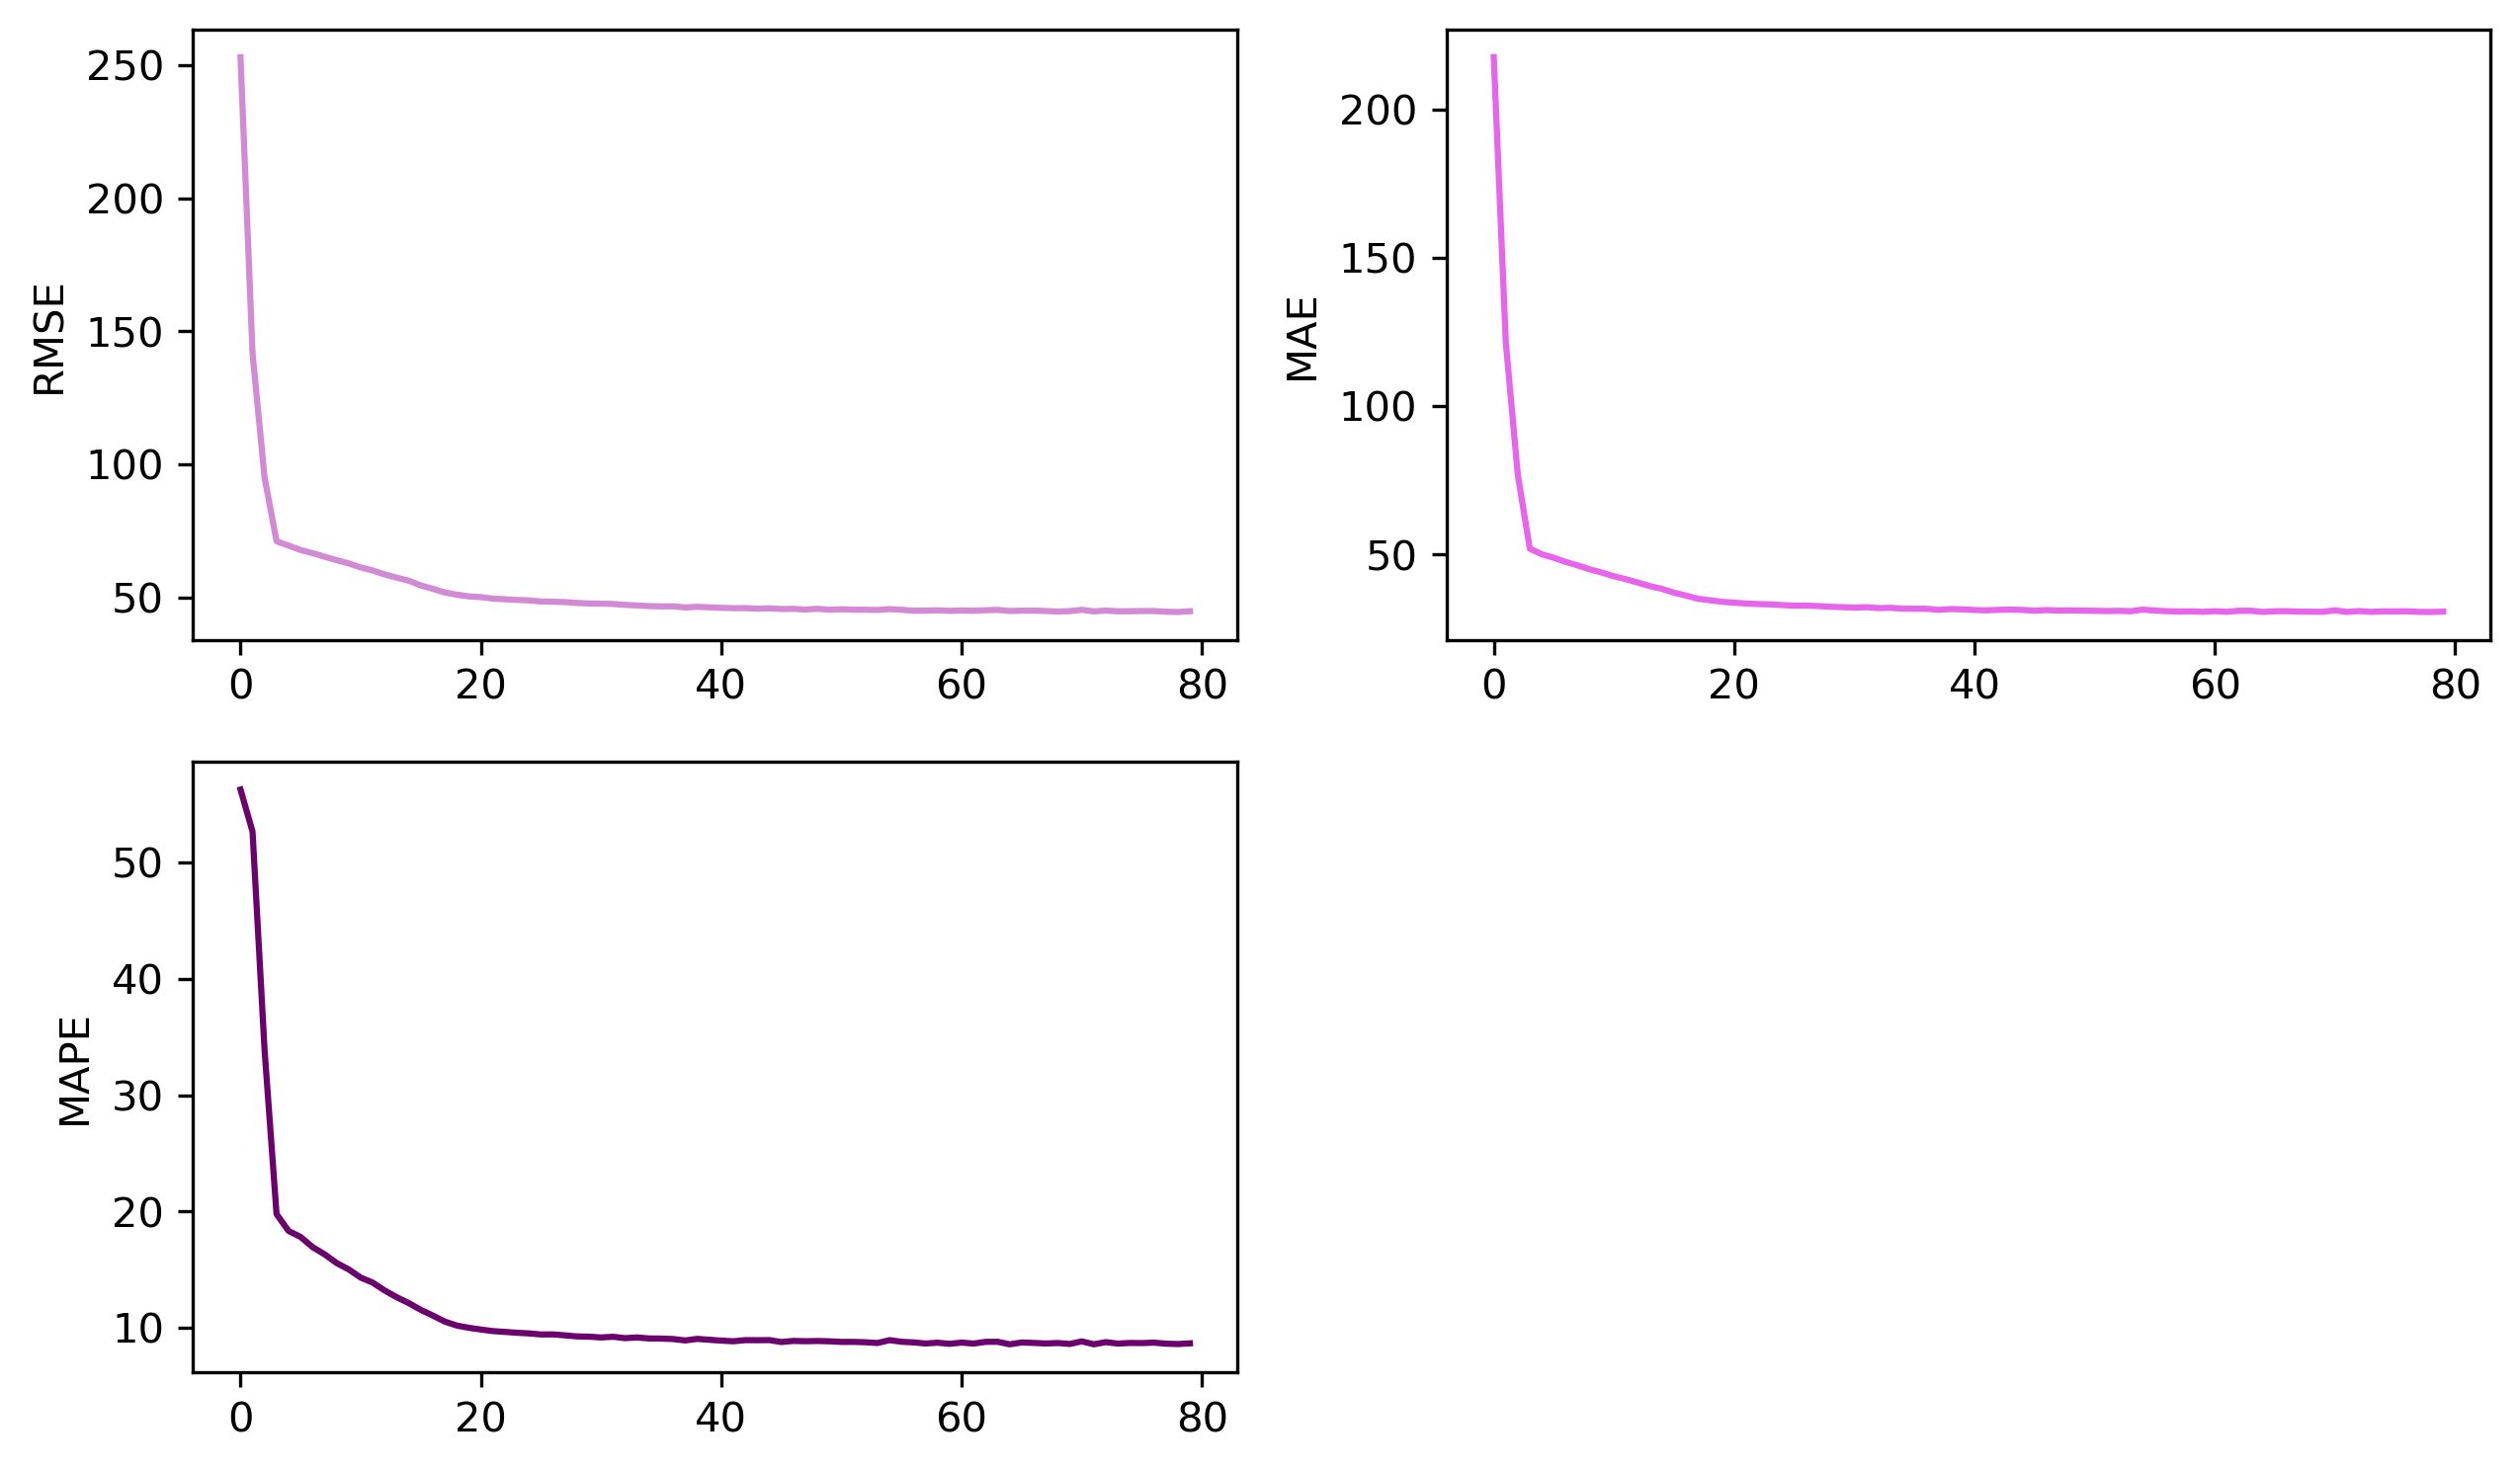

In [18]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

---

# 三、任务3

## 3.1 任务内容：手动或调用接口方式实现GRU

1. 任务具体要求：采用手动方式以及调用接口方式实现GRU，并在至少一种数据集上进行实验
2. 任务目的：实现GRU
3. 任务算法或原理介绍
4. 任务所用数据集：高速公路车流量数据集

## 3.2 任务思路及代码

> 以文本步骤的形式简要介绍代码思路
1. 步骤1：读取数据
2. 步骤2：定义模型
3. 步骤3：训练模型

## 3.3 实验结果分析

**手动实现GRU**

In [19]:
class My_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.gates = nn.Linear(input_size+hidden_size, hidden_size*2)
        # 用于计算candidate hidden state
        self.hidden_transform = nn.Linear(input_size+hidden_size, hidden_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
            
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []
        for i in range(seq_len):
            update_gate, reset_gate = self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(2, -1)
            update_gate, reset_gate = (self.sigmoid(gate) for gate in (update_gate, reset_gate))
            candidate_hidden = self.tanh(self.hidden_transform(torch.cat([x[:, i, :], reset_gate * h], dim=-1)))
            h = (1-update_gate) * h + update_gate * candidate_hidden
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), h

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

my_rnn = My_GRU(input_size, hidden_size, output_size).to(device)

optimizer = torch.optim.Adam(my_rnn.parameters(), lr)

In [21]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [22]:
from utils import *

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.0169, train rmse 143.7587, val loss 0.0050, val rmse 74.652794, time use 4.591s
*** epoch2, train loss 0.0025, train rmse 55.6931, val loss 0.0021, val rmse 42.192841, time use 4.804s
*** epoch3, train loss 0.0019, train rmse 48.6894, val loss 0.0020, val rmse 40.985563, time use 6.048s
*** epoch4, train loss 0.0018, train rmse 47.6107, val loss 0.0019, val rmse 39.874149, time use 5.858s
*** epoch5, train loss 0.0017, train rmse 46.8902, val loss 0.0019, val rmse 39.631926, time use 5.811s
*** epoch6, train loss 0.0017, train rmse 46.1806, val loss 0.0018, val rmse 38.586252, time use 5.691s
*** epoch7, train loss 0.0017, train rmse 45.5964, val loss 0.0018, val rmse 38.221623, time use 6.118s
*** epoch8, train loss 0.0016, train rmse 45.5421, val loss 0.0018, val rmse 37.851174, time use 5.996s
*** epoch9, train loss 0.0016, train rmse 45.4068, val loss 0.0018, val rmse 40.209296, time use 5.817s
*** epoch10, train loss 0.0016, train rmse 45.0630, val loss 0.

*** epoch80, train loss 0.0015, train rmse 43.9242, val loss 0.0017, val rmse 36.305131, time use 5.929s

****************************************
Final result:
Get best validation rmse 36.3051 at epoch 79
Total time 480.56s

Test result:
Test RMSE: 35.31363601906561    Test MAE: 24.518031163649127    Test MAPE: 7.623462622815913


### 3.3.1 手动实现GRU结果分析

手动实现GRU，随着训练次数增加，训练集和测试集预测的误差值loss呈先下降后平缓的大致趋势，证明了模型有很强的学习能力。模型大概训练时间为8min左右，比手动实现RNN要时间更长一些。

具体结果如下图所示。

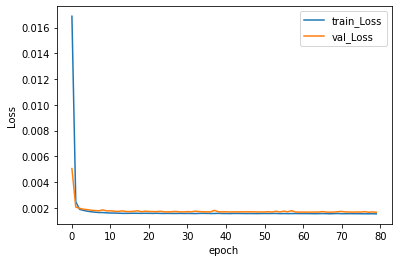

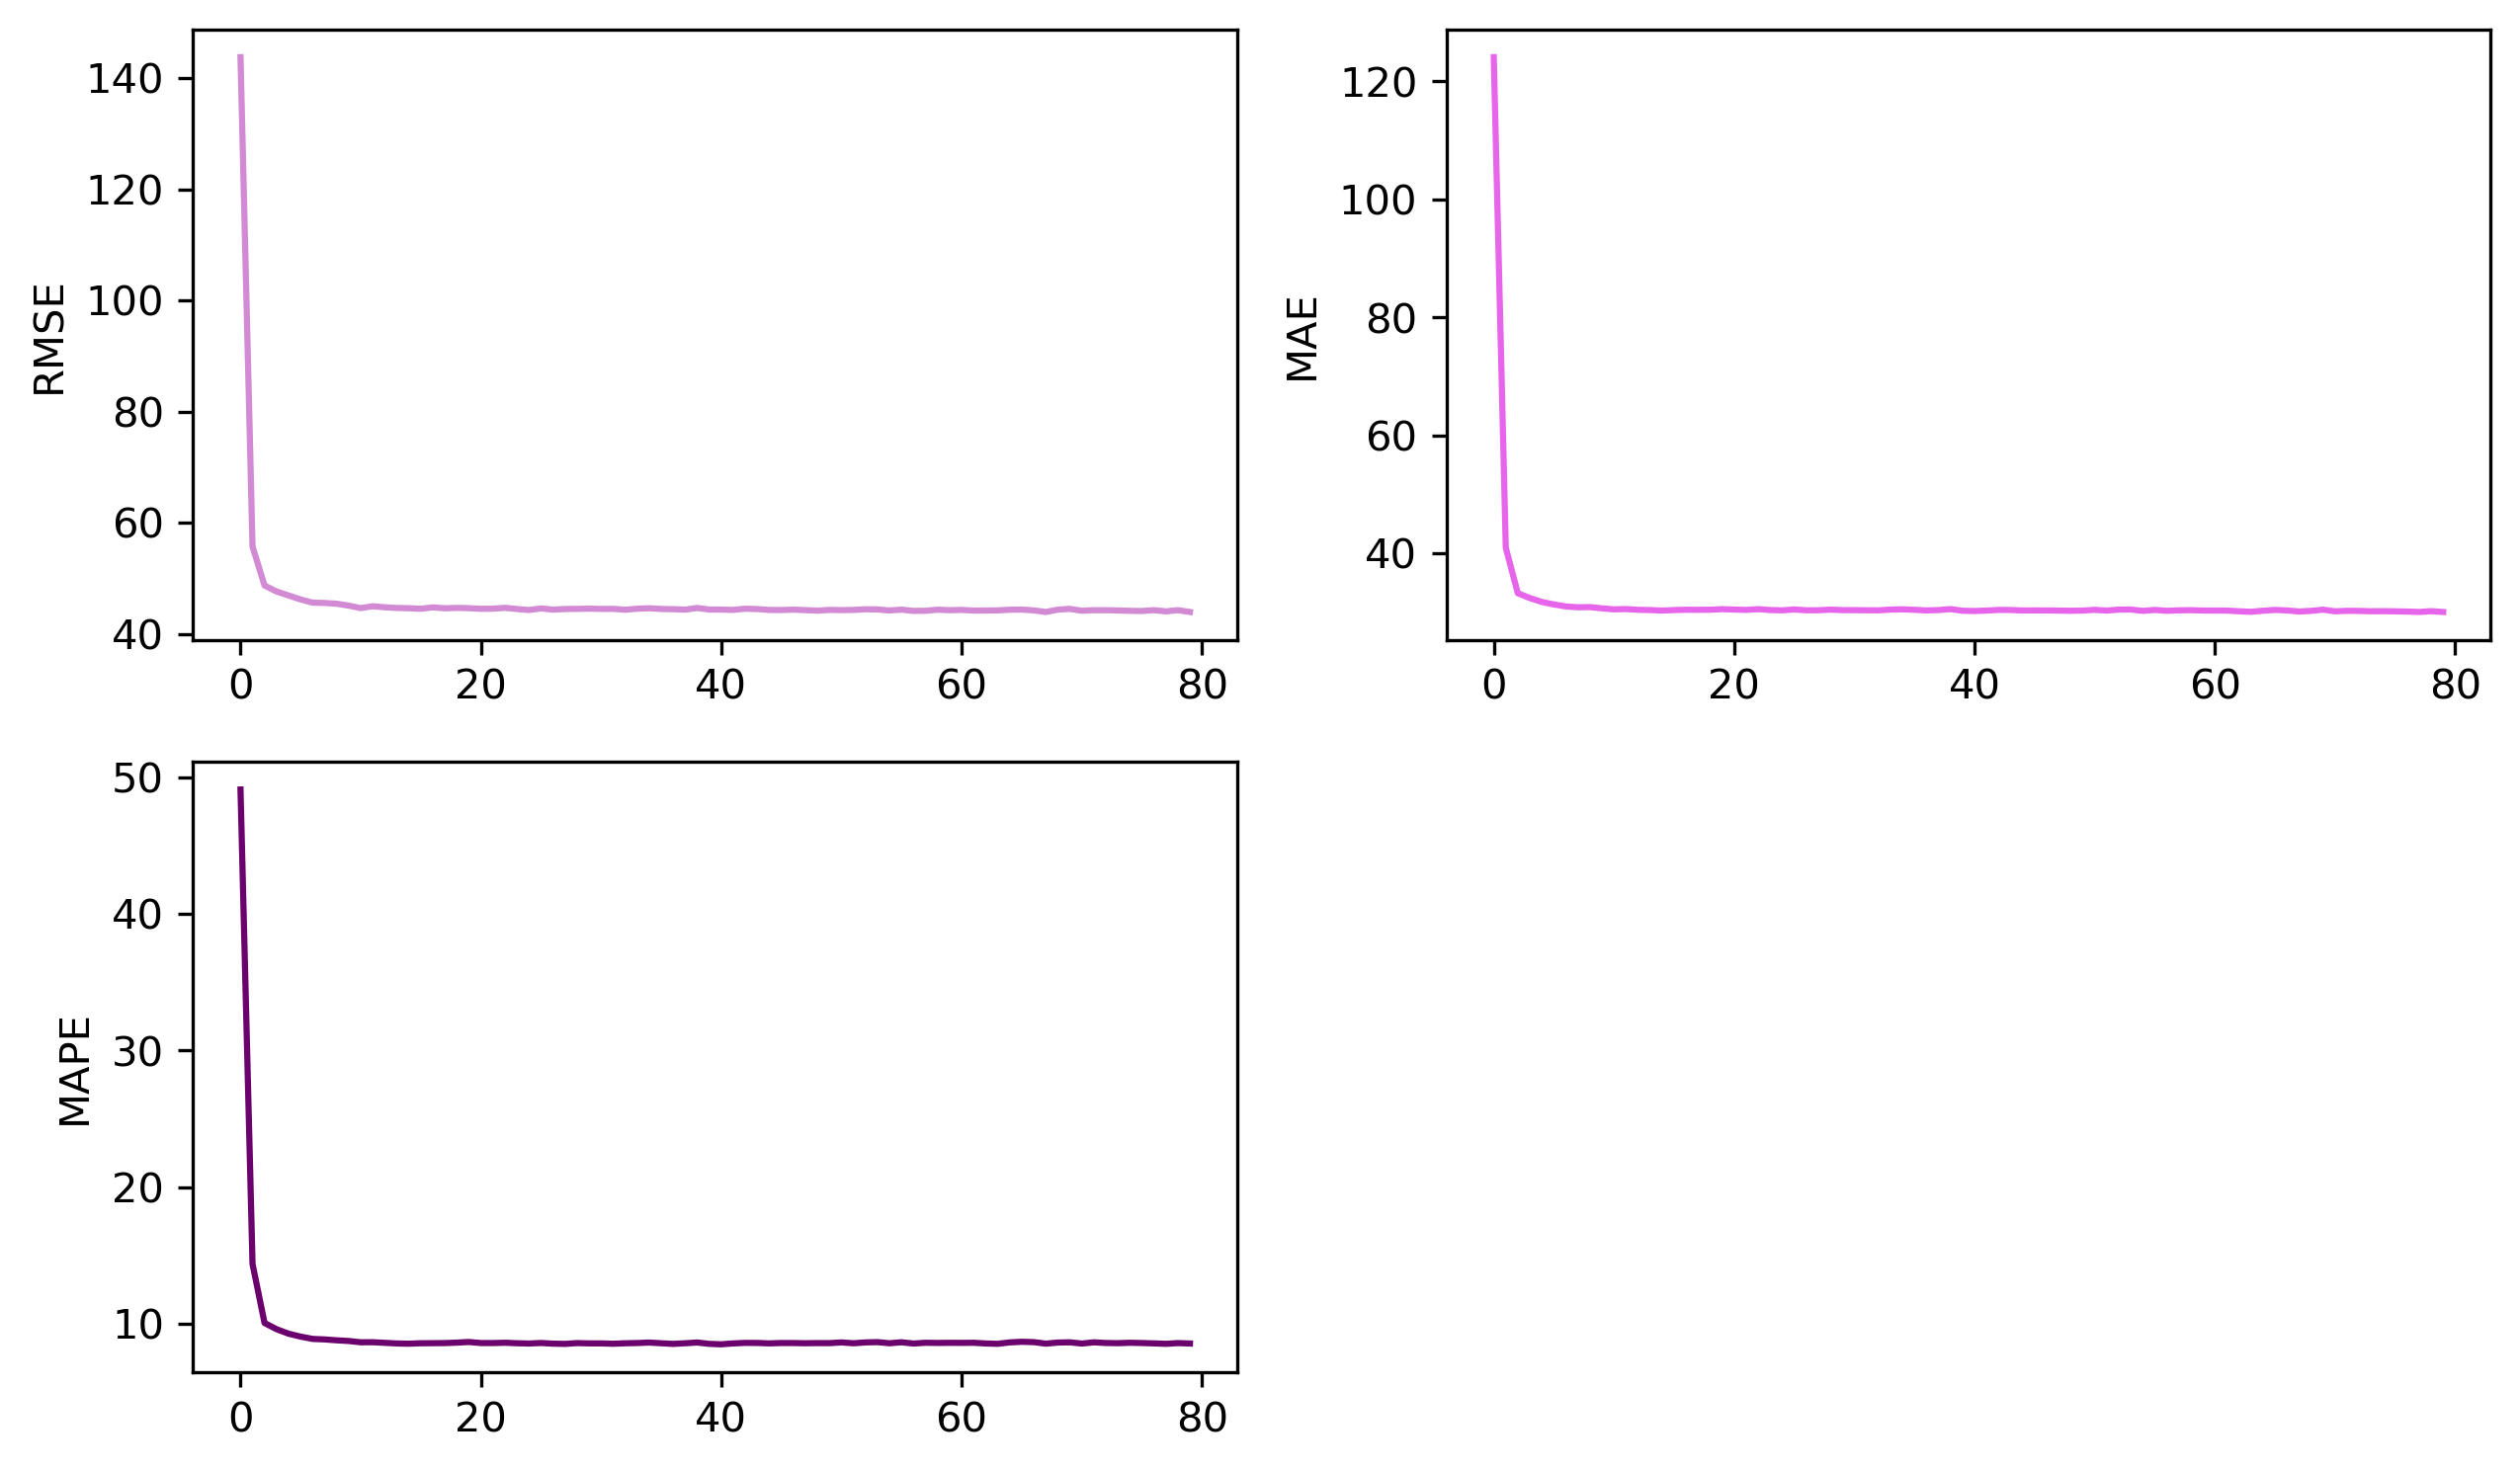

In [23]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

**使用封装的GRU**

In [24]:
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

nn_rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch1, train loss 0.0403, train rmse 217.2764, val loss 0.0147, val rmse 126.239473, time use 3.197s
*** epoch2, train loss 0.0137, train rmse 133.8531, val loss 0.0105, val rmse 106.951836, time use 3.452s
*** epoch3, train loss 0.0080, train rmse 101.3325, val loss 0.0045, val rmse 69.521670, time use 3.468s
*** epoch4, train loss 0.0031, train rmse 62.7958, val loss 0.0027, val rmse 50.881808, time use 4.110s
*** epoch5, train loss 0.0026, train rmse 57.6791, val loss 0.0026, val rmse 49.845043, time use 3.997s
*** epoch6, train loss 0.0025, train rmse 56.4692, val loss 0.0025, val rmse 48.550384, time use 3.960s
*** epoch7, train loss 0.0024, train rmse 55.2104, val loss 0.0025, val rmse 47.302690, time use 4.043s
*** epoch8, train loss 0.0023, train rmse 54.2072, val loss 0.0024, val rmse 46.554100, time use 3.921s
*** epoch9, train loss 0.0022, train rmse 53.1386, val loss 0.0023, val rmse 45.215778, time use 4.185s
*** epoch10, train loss 0.0021, train rmse 52.0331, val los

*** epoch80, train loss 0.0016, train rmse 44.8336, val loss 0.0017, val rmse 37.039526, time use 4.024s

****************************************
Final result:
Get best validation rmse 36.8503 at epoch 75
Total time 324.73s

Test result:
Test RMSE: 36.00838895553402    Test MAE: 25.23075462688099    Test MAPE: 7.924690039997751


### 3.3.2 调用接口方式实现GRU结果分析

调用接口方式实现GRU，随着训练次数增加，训练集和测试集预测的误差值loss呈先下降后平缓的大致趋势，证明了模型有很强的学习能力。模型大概训练时间为5min左右，比手动实现RNN要时间更长一些。

具体结果如下图所示。

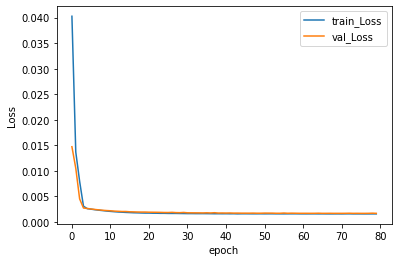

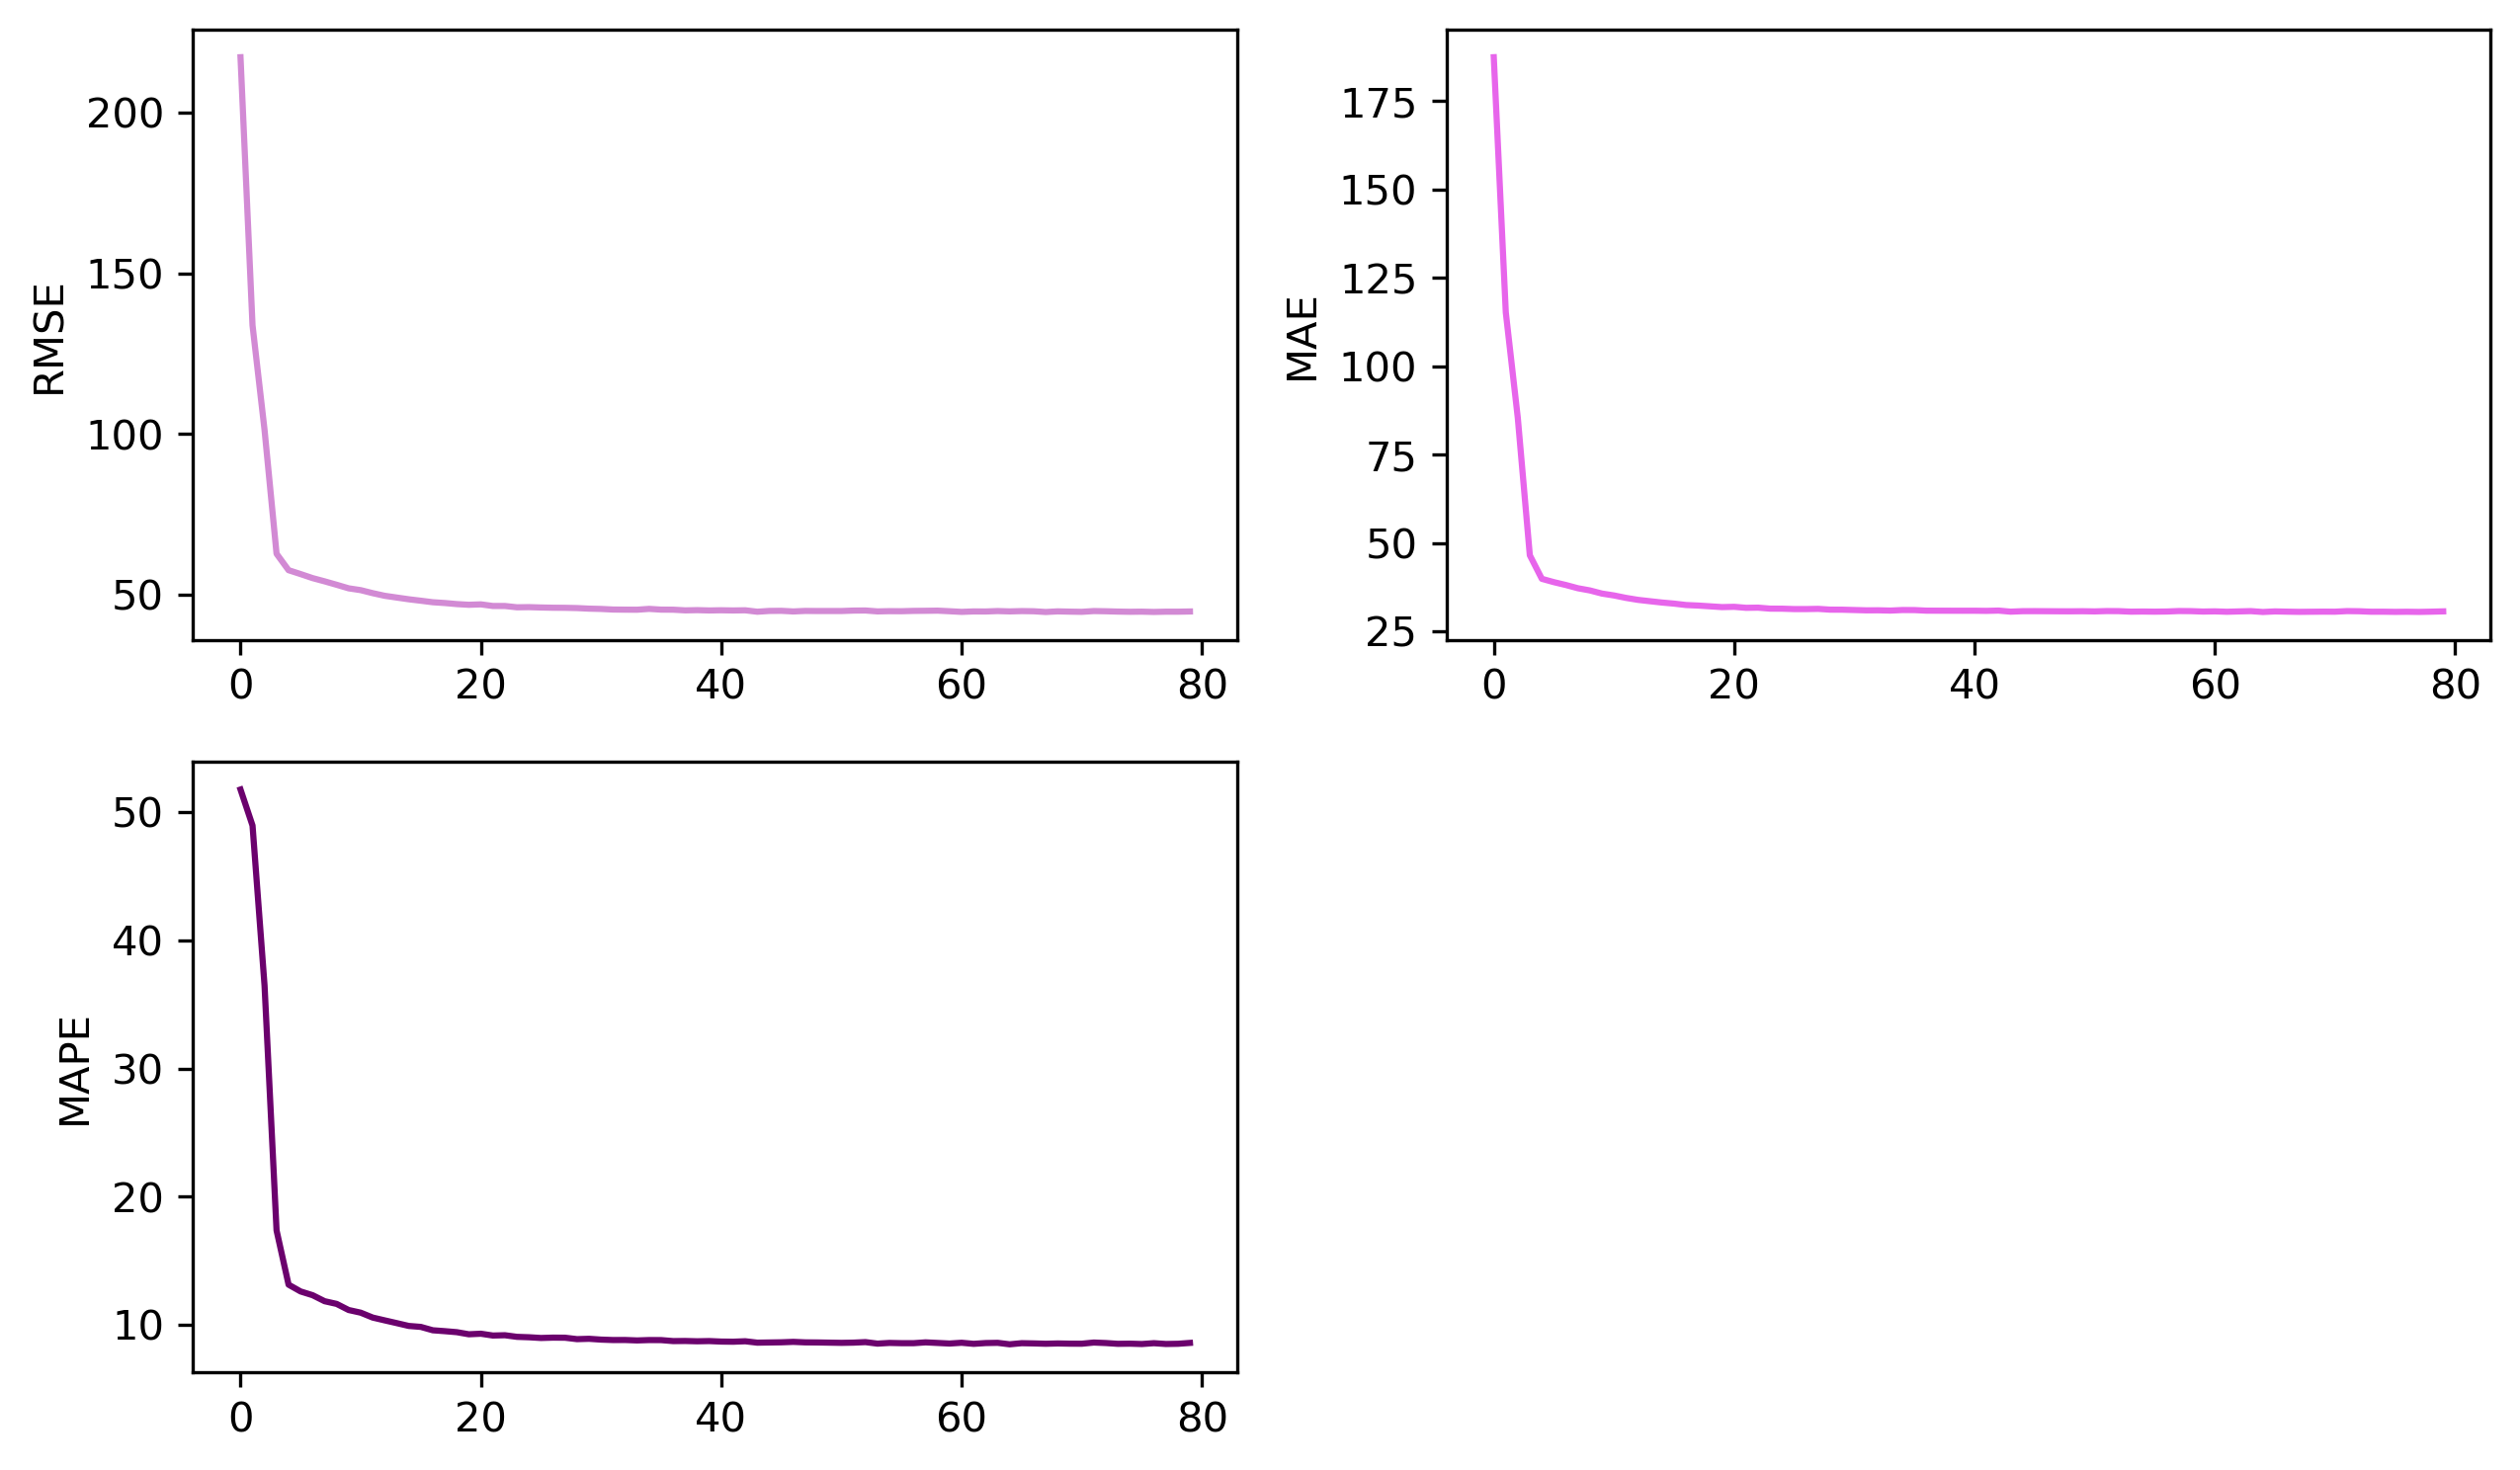

In [25]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

---

# 四、任务4

## 4.1 任务内容：LSTM的超参数对比

1. 任务具体要求：在LSTM基础上，完成不同超参数的对比（包括hidden_size、batch_size、lr等）选其中至少1-2个进行分析
2. 任务目的：LSTM超参数对比
3. 任务算法或原理介绍
4. 任务所用数据集：高速公路车流量数据集

## 4.2 lr结果对比
1.lr=0.0001
结果如上，手动实现LSTM实验<p>
2.lr=0.001
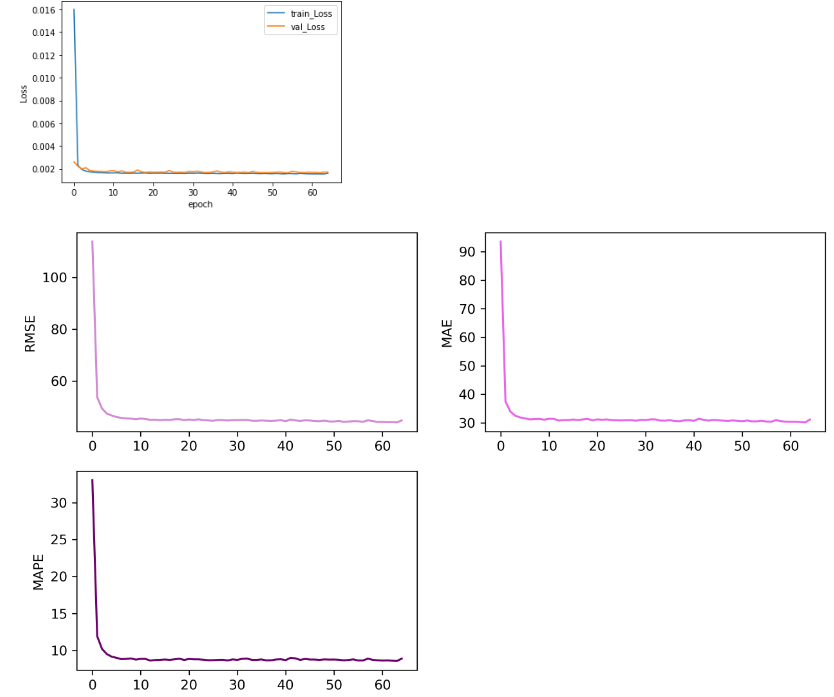<p>
3.lr=0.01
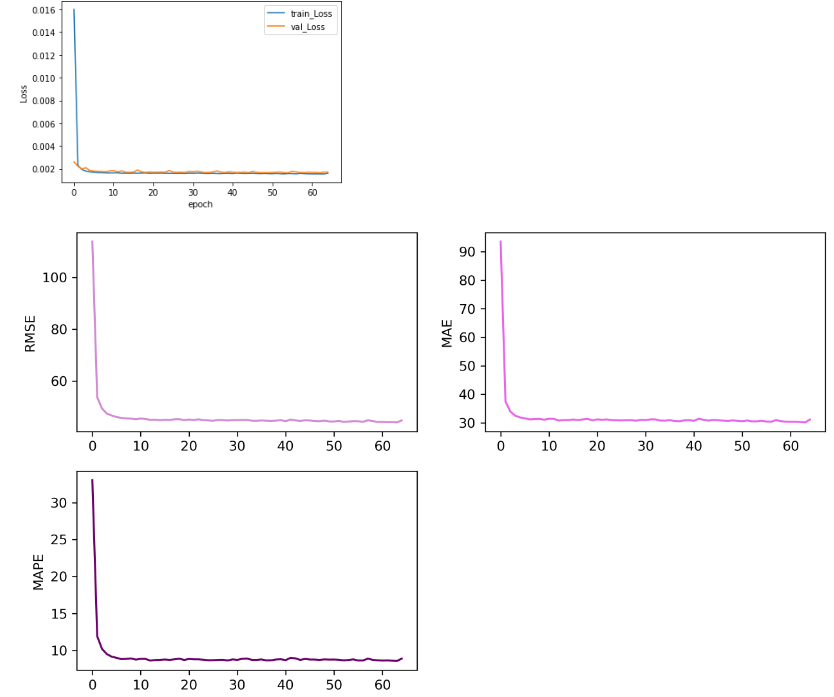<p>
<p>    
结论：lr值越大，模型收敛效果越不好，模型学习能力越弱。

---

# A1 实验心得

   实验是个将课堂知识与动手实践融会贯通的部分，在这次的实验过程中我对循环神经网络（包括RNN、LSTM、GRU）的基本原理和实现逻辑有了更清楚的认识，这次的补充代码也让我对于滑动窗口的内容有了更深刻的认识。虽然在这次实验问题上碰上了一些错误操作，比如batch_first需要设置为True，但有师兄课堂的专门强调和参考代码的提供，以及同学的帮助下成功解决了问题，完成了对RNN、LSTM及GRU模型的实现。我也对于深度学习实验代码的编写也有了很大的提升，收获满满。

# A2 参考文献

无

# A3 书写规范

## A3-1 注意中英文规范及表述
1. 在正确的位置使用正确的中英标点
   1. 在公式中请使用`,`而不是`，`；
   2. 在正常行文中，若中文则使用`，`而不是`,`，同时切忌中英标点混用。
2. 分点结尾标点符号：最后一个分点之前的每句话结尾使用分号，最后一个分点使用句号；
3. 检查错别字：“意味着”而不是“意味这”；
4. 尽量使用简要书面语，如：
    |原表达|简要书面语|
    |-|-|
    |如果|若|
    |也就是、就是、实际上|即|
    |的时候|时|
    |刚刚好（叠词）|刚好、恰|
5. 避免在没有给出证明的情况下使用“完美”、“完全”、“消除”、“彻底”等绝对表述；

## A3-2 非必要时请避免使用如下内容
1. `划去线`：即四个波浪号包裹~~目标文段~~，将降低文档可读性；
2. `无序号分点`：即`*`、`-`、`+`等，将降低文档可读性；
3. `口语化表达`：如反问句（如“那么什么时候为0呢？”）、人称代词（如“我们”）等；

## A3-3 图表
1. 截图请保证图片的分辨率；
2. 请使用Markdown中的表格语法添加表格；若使用工具包输出表格则应注意保留输出；
3. 应对贴出的图和表进行描述（如趋势等），同时分析出现相关现象的原因。

## A3-4 结构
1. 尽可能使用`序号分点`：
   1. 能够快捷换行，否则需要`两个回车或是两个空格加回车`才能换行；
   2. 能够使文档具有结构性，层次鲜明而便于阅读；
   3. 相较`无序号分点`有更强的层次感；
2. 标题级别或分点列表非必要不要到三级标题（即`###`）：避免文档层次过深，结构冗杂；
3. 插入多媒体信息（包括图片、表格、代码块等）时，若上一级是`分点列表`，应另起一行（避免渲染时可能会出现缩放降低可读性），并在其父级范围内插入而不是与父级同级位置插入（提高结构性，使其能够进行折叠）：

## A3-5 引用和注释
1. 超链接引用格式为`[]()`（如`[百度](baidu.com)`）；
2. 使用`>`引用块来表示需要“注”的内容。

## A3-6 高亮
1. 使用`上逗号`（即<kbd>Esc</kbd>键下方的键）对`英文`或`引言`等进行包裹，通过`vscode`的高亮渲染提高文档可读性（而不是使用双引号等）；
2. 使用**着重语法**（即四个星号）对一些重点信息进行加粗；
3. 使用`代码块`包裹代码，并标注该代码块使用的语言，以便渲染器进行语法渲染；

## A3-7 代码
1. 代码块中的代码应当保证语法正确性：
   1. 避免：代码本身就出错了（没有正确缩进）
      ```python
         def func(params):
         print(1)
      ```
   2. 提倡：
      ```python
         def func(params):
            print(1)
      ```
2. 粘贴的代码应为`最小可执行单元`，即可以直接复制后粘贴使用，避免有一些前置的超参数，若不可避免应说明：
   1. 避免：有未知格式的超参数STYLE_DICT
      ```python
         from config import STYLE_DICT
         # 定义函数
         def style_format(style_dict:dict):
            pass
         # 调用函数
         style_format(STYLE_DICT)
      ```
   2. 提倡：若有未知格式的超参数则至少需要说明其结构：
      ```python
         from config import STYLE_DICT
         # 定义函数
         def style_format(style_dict:dict):
            """
            @param style_dict: 其结构为……
            """
            pass
         # 调用函数
         style_format(STYLE_DICT)
      ```